In [1]:
from model import NucleationGrowthModel, solve_agg, solve_nuc_gr_agg 
from rsc.utils import read_config, save_results
from glob import glob
import numpy as np


config = read_config()
model = NucleationGrowthModel(config)

agg_sol = solve_agg(agg=0, **config['sim_params']).sol

results = solve_nuc_gr_agg(model, config, agg_sol)

save_results(results, model, config)


model.K.R_cap

100%|█████████▉| 100/100 [00:00<00:00, 290it/s]


2.038113126701897e-09

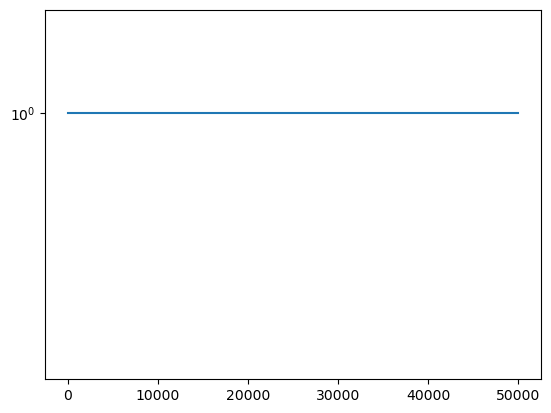

In [26]:
from rsc import read_results
import pandas as pd

df = read_results(glob('./results/*/*5')[-1])

df[['Au+', 'Au0', 'Au0_nuc']], df.filter(regex='Au0_gr')


# stack data frames horizontally
pd.concat([df[['Au+', 'Au0', 'Au0_nuc']], df.filter(regex='Au0_gr')], axis=1)
# row wise sum
row_sum = pd.concat([df[['Au+', 'Au0', 'Au0_nuc']], df.filter(regex='Au0_gr')], axis=1).sum(axis=1)

# plot  
import matplotlib.pyplot as plt

plt.plot(df['t'], row_sum)
# axlimits between 0 and 2
plt.ylim(0.99, 1.01)
# double log from 1 
plt.yscale('symlog', linthresh=1.0)

NameError: name 'gather_legend' is not defined

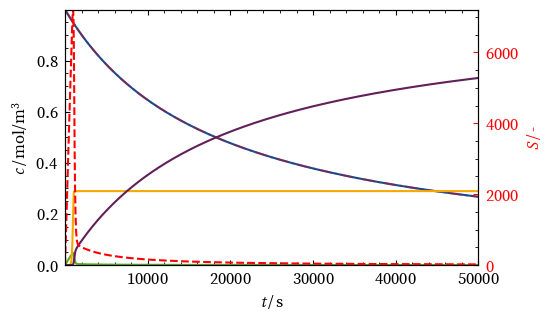

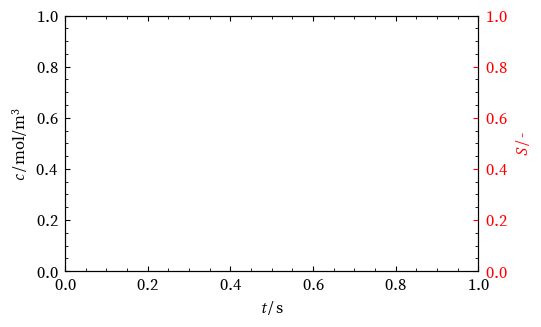

In [1]:
from plots import plot_defaults, time_vs_concentration, time_vs_saturation, number_vs_size, number_vs_size_scatter, time_vs_variance, create_basic_plot, ctwinx, create_dual_plot, gather_legend
from rsc import read_results
from glob import glob
import numpy as np

df = read_results(glob('./results/*/*5')[-1])


axlabels = {
        'time': '$t\,/\,$s',
        'radius': '$r\,/\,$m',
        'conc': '$c\,/\,$mol/m$^3$',
        'sat': '$S\,/\,$-',
    }



plot_func = [time_vs_concentration, time_vs_saturation, number_vs_size, number_vs_size_scatter, time_vs_variance]

fig, ax_main = create_basic_plot(axlabels['time'], axlabels['conc'])
ax_right = ctwinx(ax_main, 'red', axlabels['sat']) 

time_vs_concentration(df, ax_main)
time_vs_saturation(df, ax_right, 'red')



create_dual_plot(axlabels['time'], axlabels['conc'], axlabels['sat'])




axs = [ax_main, ax_right]

gather_legend(axs)

ax_main.legend(handles, labels, loc='upper right')


# function for this dual figure





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


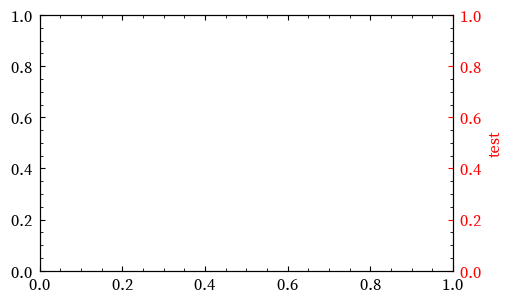

In [5]:
%load_ext autoreload
from plots import ctwinx, plot_defaults

fig, gs = plot_defaults(1, 1)
ax_main = fig.add_subplot(gs[0, 0])
ax_right = ctwinx(ax_main, 'red', 'test')

In [ ]:
from plots import plot_defaults, time_vs_concentration, time_vs_saturation, number_vs_size, number_vs_size_scatter, time_vs_variance
from rsc import read_results

df = read_results(glob('./results/*/*5')[-1])

plot_func = [time_vs_concentration, time_vs_saturation, number_vs_size, number_vs_size_scatter, time_vs_variance]

for funcs in plot_func:
    fig, gs = plot_defaults(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    funcs(df, ax)


In [ ]:
def execute_every_5_calls(func):
    def wrapper(*args, **kwargs):
        wrapper.num_calls += 1
        if wrapper.num_calls % 5 == 0:
            return func(*args, **kwargs)
    wrapper.num_calls = 0
    return wrapper

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import numpy as np

@execute_every_5_calls
def clear():
    clear_output()

def get_size(df):
    # Select columns corresponding to particle size R and number of particles P
    R_col = df.columns[df.columns.str.startswith('R')]
    P_col = df.columns[df.columns.str.startswith('P')]

    # Convert particle size to nanometers and extract data as numpy arrays
    R = df[R_col].to_numpy() * 1e9
    P = df[P_col].to_numpy()

    # Only include rows where there are non-zero number of particles
    cnd = P.sum(axis=1) > 0
    R = R[cnd]
    P = P[cnd]

    # Extract time values for plotting
    t = df.t[cnd]

    # Calculate weighted variance of particle size distribution
    weighted_avg = np.average(R, axis=1, weights=P)
    return t, weighted_avg


t_R, R, dr = np.loadtxt("data/Time_vs_radius1800.csv", delimiter=",").T
t, Var = np.loadtxt("data/Time_vs_pdi1800.csv", delimiter=",").T




def fit_size(x0, *args):
    gamma, E_1, E_gr, E_sol, E_agg = x0
    t_R, R = args
    model.config['const']['gamma'] = gamma
    model.config['activation']['E_1'] = E_1
    model.config['activation']['E_gr'] = E_gr
    model.config['activation']['E_sol'] = E_sol
    model.config['activation']['E_agg'] = E_agg
    model.__init__(config) # RESET MODEL INNIT
    results = solve_nuc_gr_agg(model, config, agg_sol)
    clear()
    df = pd.DataFrame(results, columns=model.columns)
    t, R_ode = get_size(df)
    R_dat = np.interp(t, t_R, R)

    print(f"Error: {np.sum((R_ode - R_dat)**2)}")
    error = np.sum((R_ode - R_dat)**2)
    return error
    

res = minimize(
    fit_size,
    x0=[245, 55, 45, 1, 90],
    args=(t_R, R),
    method='Nelder-Mead',
    bounds=[(210, 300),(35, 55), (20, 80), (0.1, 10), (10, 200)],
    options={'disp': True})









In [ ]:
gamma, E_1, E_gr, E_sol, E_agg = res.x
model.config['const']['gamma'] = gamma
model.config['activation']['E_1'] = E_1
model.config['activation']['E_gr'] = E_gr
model.config['activation']['E_sol'] = E_sol
model.config['activation']['E_agg'] = E_agg
model.__init__(config) # RESET MODEL INNIT
results = solve_nuc_gr_agg(model, config, agg_sol)


df = pd.DataFrame(results, columns=model.columns)
t, R_ode = get_size(df)

save_results(results, model, config)

In [ ]:
res.x

In [ ]:
from plots import plot_defaults, time_vs_size, number_vs_size_scatter, time_vs_concentration, time_vs_saturation, number_vs_size, time_vs_variance

save_results(results, model, config)



df = read_results("./results/DefaultParams_2023-02-24_07-52-01/data.h5")



R_dat = np.interp(t, t_R, R)
fig, gs = plot_defaults(2, 2, 30)
# adjust subplot spacing
gs.update(wspace=0.3, hspace=0.3)
ax_top = fig.add_subplot(gs[0, :])
time_vs_concentration(df, ax_top)
ax_top_twin = ax_top.twinx()
time_vs_saturation(df, ax_top_twin)
ax_l = fig.add_subplot(gs[1, 0])
ax_r = fig.add_subplot(gs[1, 1])
time_vs_size(df, ax_l)
ax_l.plot(t, R_dat, label="Data Radius")
ax_l.legend()
number_vs_size(df, ax_r)


ax.legend()


In [ ]:
from rsc import read_results
from plots import PlotManager, Plot, time_vs_concentration, time_vs_saturation


df = read_results('./results/DefaultParams_2023-02-21_10-22-08/data.h5')


plots = [
    Plot('time_vs_concentration', 'time', 'conc', time_vs_concentration),
    Plot('time_vs_saturation', 'time', 'conc', time_vs_concentration),
    Plot('time_vs_PDI', 'time', 'pdi', None),
    Plot('R_vs_P_scatter', 'radius', 'number', None),
    Plot('R_vs_P_histogram', 'radius', 'number', None),
]
pm = PlotManager('/DefaultParams_2023-02-21_10-22-08/', plots)

pm.save_plots(df)

In [ ]:
def plot_single(**kwargs):
    print(kwargs)
    return kwargs.get('xxlabel', '')
plot_single(xlabel='test')



In [ ]:

%matplotlib inline

from plots import num_vs_size_hist
from rsc import read_results

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
import numpy as np

def log_normal(x, mu, sig):
    f = 1 / (x * sig * (2 * np.pi)**0.5)

    exp = np.exp(
         - (np.log(x) - mu)**2 / 
         (2 * sig**2)
    )

    return f * exp

df = read_results('./results/DefaultParams_2023-02-21_10-22-08/data.h5')

mu_l = []
sig_l = []
for i in range(20, 1000):
    P_col, R_col = num_vs_size_hist(df, 1)

    R = df[P_col].iloc[i,:] * 1e9
    P = df[R_col].iloc[i,:]
    P = P



    #plt.hist(R , bins=20, weights=P, label='rel. freq. of Particle Size')



    #plt.hist(R , bins=10, weights=P, label='rel. freq. of Particle Size', density=True)

    bin_heights, bin_borders = np.histogram(R, bins=10, weights=P, density=True)
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2
    popt, _ = curve_fit(log_normal, bin_centers, bin_heights, p0=[2.1, .1])

    #plt.plot(t, log_normal(t, *popt))
    mu, sig = popt
    mu_l.append(mu)
    sig_l.append(sig)

mu_l = np.array(mu_l)
sig_l = np.array(sig_l)


In [ ]:
var = (np.exp(sig_l**2) - 1)*(np.exp(2*mu_l + sig_l**2))

In [ ]:
plt.plot(sig_l)
plt.ylim(0,10)

In [ ]:
def log_normal(x, mu, sig):
    x = np.array(x)
    f = 1 / (x * sig * (2 * np.pi)**0.5)

    exp = np.exp(
        - (np.log(x) - mu)**2 / 
        (2 * sig**2)
    )

    return f * exp

t = np.arange(0.001, 20, 0.001)
plt.plot(t, log_normal(t, 0.2, 0.08))
plt.plot(t, g(t, 2, 0.1))

In [ ]:
def log_normal(x, mu, sig):
    x = np.array(x)
    f = 1 / (x * sig * (2 * np.pi)**0.5)

    exp = np.exp(
        - (np.log(x) - mu)**2 / 
        (2 * sig**2)
    )

    return f * exp

t = np.arange(0.001, 20, 0.001)
plt.plot(t, log_normal(t, 0.2, 0.08))
plt.plot(t, g(t, 2, 0.1))

In [ ]:
a

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
%matplotlib inline

from plots import num_vs_size_hist
from rsc import read_results

import matplotlib.pyplot as plt

df = read_results('./results/DefaultParams_2023-02-21_10-22-08/data.h5')

P_col, R_col = num_vs_size_hist(df, 1)

plt.plot(df[R_col].iloc[-1,:])